# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0a3f72895fefac8f7e1aa2631a333270444fc504e65bba3f8f07f29109596bb7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=0665f8f4f81960c6b5e2113fabf91a5d8121cb2d400f6eb8baa230300d609b0c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

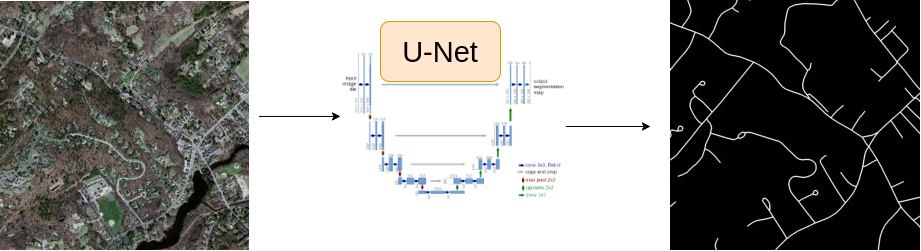

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 40.72 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [6]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [7]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [27]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset'

DEVICE = 'cuda'

EPOCHS = 5
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [28]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [29]:
idx = 15

row = df.iloc[idx]

# Extract image and mask paths
image_loc = row.images
mask_loc = row.masks

image_full_path = '/content/Road_seg_dataset/' + image_loc # Corrected: adding the file name
mask_full_path = '/content/Road_seg_dataset/' + mask_loc # Corrected: adding the file name


image = cv2.imread(image_full_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE) / 255.0

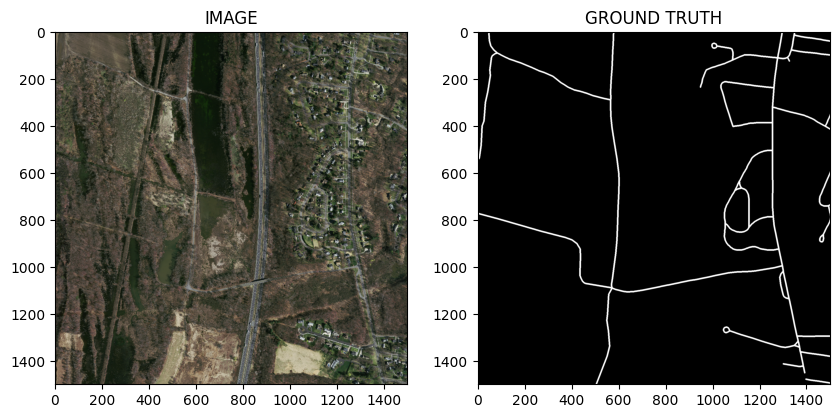

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [31]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [32]:
import albumentations as A

In [33]:
def get_train_augs():
    return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
    return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [34]:
from torch.utils.data import Dataset

In [35]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_loc = row.images
        mask_loc = row.masks

        image_full_path = '/content/Road_seg_dataset/' + image_loc # Corrected: adding the file name
        mask_full_path = '/content/Road_seg_dataset/' + mask_loc # Corrected: adding the file name

        image = cv2.imread(image_full_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image'] #(h,w,c)
            mask =  data['mask']

            image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c, h, w)
            mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c, h, w

            image = torch.Tensor(image) / 255.0
            mask = torch.round(torch.Tensor(mask) / 255.0)


        return image, mask

In [36]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [37]:
print(f'Length of trainset : {len(trainset)}')
print(f'Length of validset : {len(validset)}')

Length of trainset : 159
Length of validset : 40


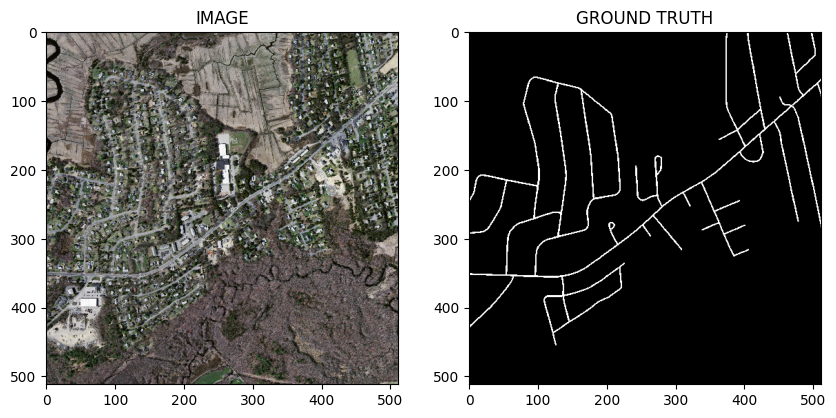

In [38]:
idx = 21

image, mask = trainset[idx]

show_image(image, mask)

# Task 5 : Load dataset into batches

In [39]:
from torch.utils.data import DataLoader

In [40]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [41]:
print(f'Total number of batches in trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 20
Total number of batches in validloader : 5


In [42]:
for images, masks in trainloader:
    print(f"One batch image shape: {images.shape}")
    print(f"One batch mask shape: {masks.shape}")
    break;

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [43]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [44]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks =None):
        logits = self.backbone(images)

        if masks != None:
            return logits, DiceLoss(mode= 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

        return logits

In [45]:
import torch

# Check if CUDA is available and set the device accordingly
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    print("CUDA is not available. Using CPU instead.")

model = SegmentationModel()
model.to(DEVICE)

CUDA is not available. Using CPU instead.


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

In [46]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [47]:
def train_fn(dataloader, model, optimizer):


    model.train()  #Turn ON dropout, batchnorm, etc..

    total_loss = 0.0

    for images, masks in tqdm(trainloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [48]:
def eval_fn(dataloader, model):

    model.eval()  #Turn OFF dropout, batchnorm, etc..

    total_loss = 0.0

    with torch.no_grad():


        for images, masks in tqdm(trainloader):

              images = images.to(DEVICE)
              masks = masks.to(DEVICE)
              logits, loss = model(images, masks)
              total_loss += loss.item()

        return total_loss / len(dataloader)

# Task 8 : Train Model

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [50]:
best_loss = np.inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_loss:

        torch.save(model.state_dict(), 'best-model.pt')
        print("SAVED-MODEL")
        best_loss = valid_loss

    print(f"EPOCH : {i+1}")
    print(f"Train Loss : {train_loss:.4f}")
    print(f"Valid Loss : {valid_loss:.4f}")

100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


SAVED-MODEL
EPOCH : 1
Train Loss : 1.0046
Valid Loss : 3.6328


100%|██████████| 20/20 [02:06<00:00,  6.32s/it]


SAVED-MODEL
EPOCH : 2
Train Loss : 0.7649
Valid Loss : 2.9878


100%|██████████| 20/20 [02:17<00:00,  6.89s/it]


SAVED-MODEL
EPOCH : 3
Train Loss : 0.7075
Valid Loss : 2.7387


100%|██████████| 20/20 [02:15<00:00,  6.80s/it]


SAVED-MODEL
EPOCH : 4
Train Loss : 0.6872
Valid Loss : 2.6340


100%|██████████| 20/20 [02:08<00:00,  6.41s/it]

SAVED-MODEL
EPOCH : 5
Train Loss : 0.6603
Valid Loss : 2.5398


# Task 9 : Inference

In [51]:
idx = 17

model.load_state_dict(torch.load('/content/best-model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) --> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-51-45268665b6e6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best-model.pt'))


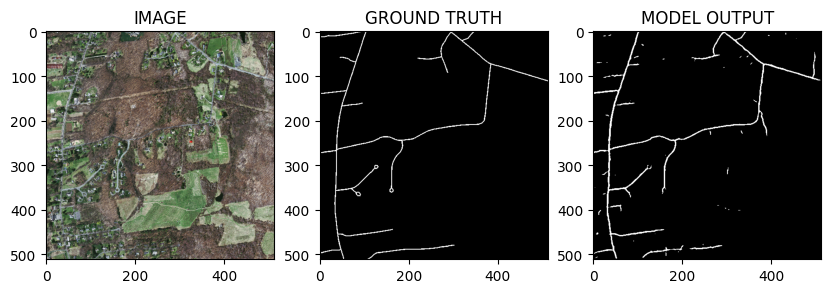

In [52]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

